This notebook experiments with the YOLOv2 algorithm. It uses the code from the [YAD2K repo](https://github.com/allanzelener/YAD2K) and takes ideas from the amazing deeplarning.ai course on Conv Nets, hosted on Coursera.

In [1]:
import numpy as np

from keras.models import load_model, Model
from keras import backend as K

from PIL import Image

%matplotlib inline

Using TensorFlow backend.


In [2]:
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, yolo_eval
from yad2k.utils import generate_colors, preprocess_image, draw_boxes, predict

Now let's load a YOLO model that was trained using the weights and configuration from YOLO's website. The model itself was created using the YAD2K code. This repo does not include the h5 files, but they could be easily generated following the instructions on the [YAD2K repo](https://github.com/allanzelener/YAD2K). You can choose from a few models that were trained either on the COCO or Pascal VOC datasets. This is why the notebook contains below different config values depending on the dataset used. There is also a choice between full YOLO and tiny YOLO. Full YOLO has a more complex structure of the conv net used and generated better results but takes longer to train and run forward prop on test images. Tiny YOLO is less accurate but much faster. Read more about it on [YOLO's website](https://pjreddie.com/darknet/yolo/). The notebook currently loads a "full" model that was generated from weights trained on the COCO dataset.


In [3]:
yolo_model = load_model("model_data/yolo.h5")

/Users/anton.dimitrov/anaconda/lib/python3.6/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [4]:
# Visualize the loaded YOLO model to see its structure
# yolo_model.summary()

We need to specify some config values to be used by the model: anchors, class names, image size as is input to the conv net. We will also specify in a global variable the size of the image to be annotated.

In [5]:
# Values used by models trained on the COCO dataset
anchors = np.array([[0.57273, 0.677385], [1.87446, 2.06253], [3.33843, 5.47434], [7.88282, 3.52778], [9.77052, 9.16828]])
class_names = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
model_image_size = (608, 608)
# Values used by models trained on the Pascal VOC dataset
# anchors = np.array([[1.08, 1.19], [3.42, 4.41], [6.63, 11.38], [9.42, 5.11], [16.62, 10.52]])
# class_names = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
# model_image_size = (416, 416)

# Size of the input image
image_shape = (361., 640.)

In [6]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

In [7]:
placeholders = yolo_eval(yolo_outputs, image_shape, max_boxes=10, score_threshold=0.5, iou_threshold=0.5)

Scores: [ 0.74955982  0.52979106  0.52665627]
Boxes: [[ 149.64640808  295.05743408  178.54673767  367.63580322]
 [  18.82799339    4.33920383  123.94538879  123.62037659]
 [  42.59788895   11.29146957   63.58828735   36.30072784]]
Found 3 boxes for stop_sign2.jpg
person 0.53 (11, 43) (36, 64)
car 0.53 (4, 19) (124, 124)
stop sign 0.75 (295, 150) (368, 179)
CPU times: user 8.87 s, sys: 884 ms, total: 9.75 s
Wall time: 4.01 s


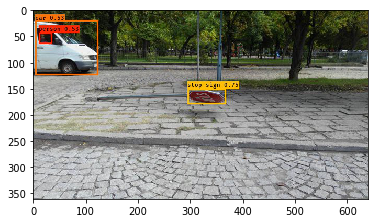

In [8]:
%time out_scores, out_boxes, out_classes = predict(K.get_session(), "stop_sign2.jpg", yolo_model, placeholders, class_names)

Now let's try to annotate some video. Reset the Keras session and set a new input image size.

In [19]:
K.clear_session()
# Size of the input image
image_shape = (665., 1280.)

In [20]:
yolo_model = load_model("model_data/yolo.h5")

In [21]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))
placeholders = yolo_eval(yolo_outputs, image_shape, max_boxes=10, score_threshold=0.5, iou_threshold=0.5)

In [22]:
from moviepy.editor import VideoFileClip

In [25]:
counter = 0
gscores = None
gboxes = None
gclasses = None

def pipeline(image_arr):
    global counter
    global gscores
    global gboxes
    global gclasses

    image = Image.fromarray(image_arr)
    image, image_data = preprocess_image(image, model_image_size = model_image_size)
    
    scores, boxes, classes = placeholders
    
    # In order to obtain a better speed of anotation we could be skipping frames, which results
    # in poorer annotations on the video but faster processing times. This is useful when running
    # on just CPU.
    if counter % 2 == 0:
        out_scores, out_boxes, out_classes = K.get_session().run([scores, boxes, classes], feed_dict={yolo_model.input: image_data, K.learning_phase(): 0})
        gscores, gboxes, gclasses = out_scores, out_boxes, out_classes
    else:
        out_scores, out_boxes, out_classes = gscores, gboxes, gclasses

    counter += 1

    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors, verbose=0)
    return np.asarray(image, dtype=np.uint8)

In [26]:
project_video_output = "out/cars_on_the_street.mp4"
clip1 = VideoFileClip("video/cars_on_the_street.mp4")
lane_clip = clip1.fl_image(pipeline)
%time lane_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video out/kola_telenor_okolovrystno_2017_11_23_v2.mp4
[MoviePy] Writing video out/kola_telenor_okolovrystno_2017_11_23_v2.mp4



100%|█████████▉| 240/241 [07:39<00:01,  1.77s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out/kola_telenor_okolovrystno_2017_11_23_v2.mp4 

CPU times: user 16min 14s, sys: 1min 32s, total: 17min 46s
Wall time: 7min 40s


An example annotated video can be seen [here](https://youtu.be/FONVGcTEAuw).